In [1]:
from fastai.vision.all import *
import torch
from fastcore.parallel import *
import timm

import gc
def clear_gpu_cache():
    gc.collect()
    torch.cuda.empty_cache()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)
set_seed(42)

cuda


**Some commonly used ways to increase the accuracy of the classifier**



1. **Data related methods**
    1. *Increase input image size*
    2. *Normalize the data*
    3. *Augement the training data* 
    4. *Progressive Resizing*
    5. *Test-Time-Augmentation (TTA)*
    
2. **Neural Network related methods**
    1. *Use larger and deeper models
    2. *Use transfer learning
    3. *Ensemble learning

3. **Loss related methods**
    1. *Wisely choosing appropriate loss function - CE Loss vs Focal Loss*
    
4. **Optimizer related improvements**
    1. *Adam vs SGD - do you know why?*
    2. *batch size*
    3. *learning rate - use one-cycle approach for superconvergence*
    
<font color="green">**Refer my blog- "Computer Vision Blogs - Improving the accuracy of your Image classifier" for detailed explanation of these concepts.**</font>

Using [Paddy classification](https://www.kaggle.com/competitions/paddy-disease-classification) dataset for experimentation.  Download it on hard drive for easy access.

In [2]:
path = Path('paddy-disease-classification')
path.ls()

(#4) [Path('paddy-disease-classification/sample_submission.csv'),Path('paddy-disease-classification/test_images'),Path('paddy-disease-classification/train.csv'),Path('paddy-disease-classification/train_images')]

In [3]:
trn_path = path/'train_images'
trn_path

Path('paddy-disease-classification/train_images')

# Check if images are of same size or different.  
- this step takes time. So, I ran it once and saved the results manually in `size_df` dataframe

In [ ]:

def f(o): return PILImage.create(o).size

# # UNCOMMENT TO RUN
# images = get_image_files(path)
# sizes = parallel(f, images, n_workers=8)
# pd.Series(sizes).value_counts()

In [4]:
size_df = pd.DataFrame([['(480, 640)', '13870'],['(640, 480)','6']], columns=['Image size', 'number'])
size_df

,Image size,number
0,"(480, 640)",13870
1,"(640, 480)",6


# 0. Baseline
- Model - `xresnet18`, trained from scratch using `fit` for 4 epochs on images resized to 224x224 


In [5]:
set_seed(42)
clear_gpu_cache()

# Create Dataoaders
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                  get_items=get_image_files, 
                  get_y = parent_label, 
                   item_tfms= Resize(224)) # Resize to 224
dls = dblock.dataloaders(trn_path, bs=64)

In [6]:
dblock.summary(trn_path)

Setting-up type transforms pipelines
Found 10407 items
2 datasets of sizes 8326,2081
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      paddy-disease-classification\train_images\tungro\100337.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=480x640
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      paddy-disease-classification\train_images\tungro\100337.jpg
    applying parent_label gives
      tungro
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(9)

Final sample: (PILImage mode=RGB size=480x640, TensorCategory(9))


Found 10407 items
2 datasets of sizes 8326,2081
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setti

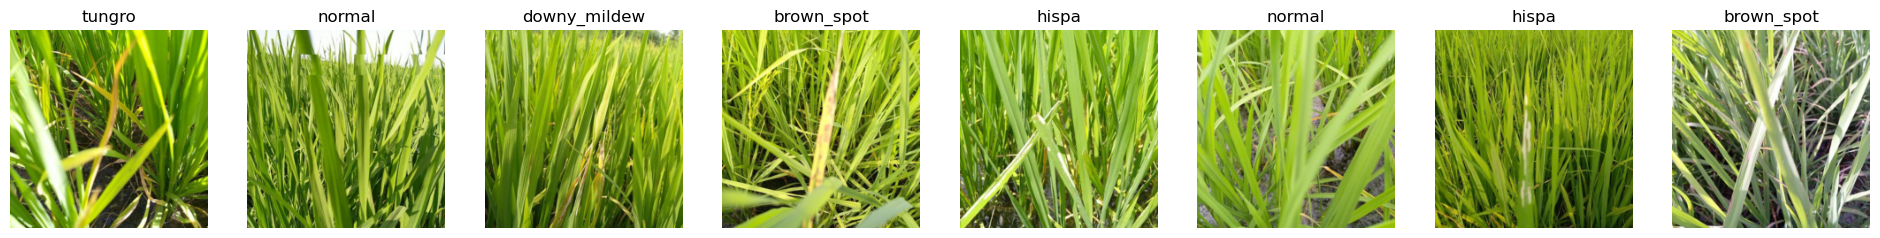

In [7]:
# Visualize some images in train dataloader
dls.train.show_batch(nrows=1, ncols=8) 

In [16]:
dls.c  # This gives number of classes

10

In [17]:
clear_gpu_cache() # free some memory in your GPU

In [18]:
# create a xresnet18 model
model = xresnet18(n_out=dls.c) # nout = number of classes
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

# train from scratch for 4 epochs using `fit` with a learning rate of 3e-3
learn.fit(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.532285,1.985017,0.405574,01:15
1,1.119485,1.620664,0.484863,01:15
2,0.847178,1.406122,0.562710,01:15
3,0.647281,1.010544,0.681884,01:16


# 1. Increase image size
- increase image size from 224 to 352

In [10]:
clear_gpu_cache() 
set_seed(42)

# create dataloader with image size of 352
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                  get_items=get_image_files, 
                  get_y = parent_label, 
                   item_tfms= Resize(352))
dls = dblock.dataloaders(trn_path, bs=64)

# create a xresnet18 model
model = xresnet18(n_out=dls.c)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

# train from scratch for 4 epochs using `fit` with a learning rate of 3e-3
learn.fit(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.562793,1.619860,0.448823,04:12
1,1.253912,1.256590,0.569918,01:33
2,0.989972,1.411976,0.574724,01:32
3,0.808192,1.276562,0.579529,01:32


# 2. `Use fit_one_cycle`
- Use `fit_one_cycle` approach by Leslie Smith for super-convergence along with augmentations on images of size 224x224.
- Conceptually `fit_one_cycle` means, we start training with a very low learning rate and then gradually increase it and then again decrease it. We start low so as not to diverge in the beginning and end low to avoid missing the minimum while in between we increase the learning rate to enable faster learning

In [19]:
clear_gpu_cache() 
set_seed(42)

dblock = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                  get_items=get_image_files, 
                  get_y = parent_label, 
                   item_tfms= Resize(224))
dls = dblock.dataloaders(trn_path, bs=64)

model = xresnet18(n_out=dls.c)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fit_one_cycle(4, 3e-3) # train from scratch with fit_one_cycle approach

epoch,train_loss,valid_loss,accuracy,time
0,1.643065,2.465880,0.321000,01:14
1,1.196506,1.529446,0.499760,01:15
2,0.750567,0.661510,0.784238,01:14
3,0.488381,0.467068,0.860644,01:12


In [20]:
clear_gpu_cache()

# 3. Augmentations
- implemented via using `aug_transforms`

In [17]:
set_seed(42)
# add aug_transforms to dataloader
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                  get_items=get_image_files, 
                  get_y = parent_label, 
                   item_tfms= Resize(460),
                  batch_tfms = aug_transforms(size=224, min_scale=0.75))
dls = dblock.dataloaders(trn_path, bs=64)

# create a xresnet18 model
model = xresnet18(n_out=dls.c)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

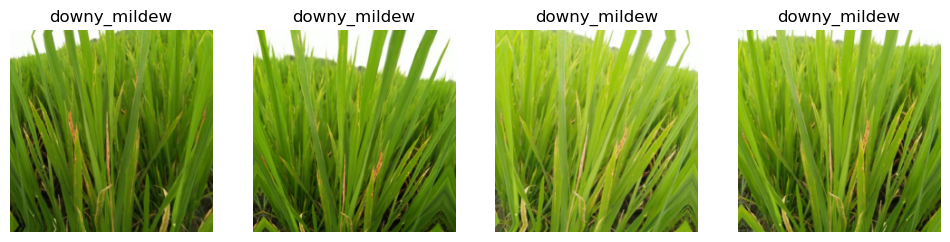

In [20]:
learn.dls.train.show_batch(max_n=4, nrows=1, unique=True)

In [52]:
# train from scratch for 4 epochs using `fit_one_cycle` with a learning rate of 3e-3
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.748814,2.455385,0.291206,01:33
1,1.362660,1.302732,0.535800,01:34
2,1.024799,0.850779,0.728496,01:33
3,0.792632,0.698974,0.780394,01:30


In [53]:
clear_gpu_cache()

**The accuracy decreased. Why?**
Visit section C of Data related improvements in the blog <font color="green">**Computer Vision Blogs - Improving the accuracy of your Image classifier**</font>

# 4. Normalization 
- for faster convergence
- Normalization helps in faster convergence. It is generally recommended to use the mean and standard deviation of the dataset that the pretrained model was originally trained on. For example, if you're using a model pretrained on the ImageNet dataset, you should use the mean and standard deviation values from the ImageNet dataset for normalization. ImageNet statistics are mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].
- If you are training from scratch then, calcualte this statistics for your own dataset as shown below

In [25]:
# number of batches in train dataloader
len(dls.train)

130

Let's calculate mean of R, G, B channels. 
- This step takes some time so, I calculated them and manually stored the values in `mean` and `std`

In [26]:
# UNCOMMENT TO RUN

# #intialise the statistics tensors
# means = tensor([0.,0.,0.]).cuda()
# stds = tensor([0.,0.,0.]).cuda()

# # caluclate number of batches in train dataset
# num_train_batches = len(dls.train)
# for x,y in dls.train:
#     means+=x.mean(dim=[0,2,3])
#     stds+=x.std(dim=[0,2,3])

# # get final statistics by dividing with the number of train batches
# means/=num_train_batches
# stds/=num_train_batches

# print('mean = {} , \n std = {}'.format(mean, std))

In [27]:
# above cell takes time to run so, I saved it here
mean = [0.4980, 0.5867, 0.2260]
std = [0.2250, 0.2243, 0.1985]

print('mean = {} , \n std = {}'.format(mean, std))

mean = [0.498, 0.5867, 0.226] , 
 std = [0.225, 0.2243, 0.1985]


In [38]:
# convert it into a form which can be used as input to the model
mean,std = broadcast_vec(1, 4, mean, std)

set_seed(42)
clear_gpu_cache()

# create a dataloader function with Normalize
def get_dls(bs,size):
    dblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                      get_items = get_image_files, 
                      get_y = parent_label, 
                      item_tfms = Resize(460), 
                      batch_tfms = [*aug_transforms(size=size, min_scale=0.75), Normalize.from_stats(mean = mean, std = std)])
    return dblock.dataloaders(trn_path, bs=bs)

dls = get_dls(64,224)
model = xresnet18(n_out = dls.c)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

# train from scratch for 4 epochs using `fit_one_cycle` with a learning rate of 3e-3
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.759005,3.652237,0.249880,01:34
1,1.365808,1.343614,0.517059,01:34
2,1.004660,0.879179,0.704469,01:37
3,0.767509,0.674080,0.791927,01:35


We can verify that our data is infact normalized. Let's see

In [37]:
x,y = dls.one_batch()
x.mean(dim=[0,2,3]), x.std(dim=[0,2,3])

(TensorImage([-0.0557, -0.0651, -0.1086], device='cuda:0'),
 TensorImage([1.0028, 1.0028, 0.9538], device='cuda:0'))

In [39]:
clear_gpu_cache()

# 3. Progressive Resizing:
- We will start with images of size 128, trained for 2 epochs and then incease the size to 224 images and trained for 4 epochs
- **Why do you think this technique might work?** Answer - Since initial layers of a NN learns basic features like edges, vertices, etc. hence, this technique is particularly useful when we do not have pretrained weights. In this case, with using small images, we can quickly learn those initial layers and then use large images to get higher discriminative power. This progressive resizing can be done in 2 stages or 3 stages or as many as you want until you reach the original resolution of images. You have to experiment to see what works for you and what does not. (It is also not absolutely necessary that this technique will always work. Use this when you don't have pretrained weights, else experiment and see)

In [40]:
set_seed(42)

# dataloader with image size of 128
dls = get_dls(64, 128)
learn = Learner(dls, xresnet18(n_out=dls.c), loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy)

# train it for 2 epochs
learn.fit_one_cycle(2, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.717904,1.940792,0.387794,01:28
1,1.245913,1.065054,0.650649,01:26


In [41]:
clear_gpu_cache()

Then you can replace the `DataLoaders` inside the `Learner`, and `fine-tune`

In [42]:
clear_gpu_cache()
set_seed(42)
# Change the dataloader with images of size 224
learn.dls = get_dls(64, 224)

# train again for 4 epochs
learn.fine_tune(4, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.135728,1.259530,0.558866,01:31


epoch,train_loss,valid_loss,accuracy,time
0,0.958668,0.891609,0.713119,01:33
1,0.876631,0.843329,0.724171,01:33
2,0.712938,0.592269,0.808746,01:33
3,0.630500,0.543918,0.833734,01:31


In [43]:
clear_gpu_cache()

You can repeat the process of increasing size and training more epochs as many times as you like, for as big an image as you wish—but of course, you will not get any benefit by using an image size larger than the size of your images on disk.

**Note that for transfer learning, progressive resizing may actually hurt performance. This is most likely to happen if your pretrained model was quite similar to your transfer learning task and dataset and was trained on similar-sized images, so the weights don't need to be changed much. In that case, training on smaller images may damage the pretrained weights.**

# 4. TTA
- It is not related to training but inferencing of the model. We apply this during inferencing where we apply augmentations to validation/ test images and get average accuracy as the final answer.

In [44]:
preds,targs = learn.tta()
accuracy(preds, targs).item()

0.8303700089454651

In [54]:
clear_gpu_cache()

The accuracy remained somewhat same, close to 83%. **Infact, it marginally decreased by 0.3%**. It means after tta, prediction of a very small number of images (0.3%) got wrong. This is probably linked to the issue highlighted in section C augmentations in Data related improvements. This is the right time to investigate what tta is doing to the test images, read the source code and modify it to make it more meaningful. [I leave it as an exercise for the reader. Comment if you face difficulty, I will be happy to help :) ]

# 5. Choosing bigger model

In [55]:
set_seed(42)
# dataloader with images of size 128
dls = get_dls(64, 128)

# use xresnet50
learn = Learner(dls, xresnet50(n_out=dls.c), loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy)

# train for 2 epochs
learn.fit_one_cycle(2, 3e-3)


epoch,train_loss,valid_loss,accuracy,time
0,1.816610,1.613099,0.419510,01:31
1,1.229620,1.015434,0.664104,01:30


In [57]:
clear_gpu_cache()
set_seed(42)

# dataloader with images of size 224
learn.dls = get_dls(64, 224)

# train for 4epochs
learn.fine_tune(4, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.125848,1.658334,0.424315,01:53


epoch,train_loss,valid_loss,accuracy,time
0,0.897653,0.888104,0.684286,01:54
1,0.849221,0.854303,0.733301,01:57
2,0.686969,0.569507,0.808746,01:55
3,0.591856,0.527352,0.836617,01:56


In [58]:
clear_gpu_cache()

# 6. Ensemble learning with larger and deeper models
- Also use pretrained weights, normalize here with <font color="red"> ImageNet statistics</font>


In [66]:
# function for dataloader with Normalize using ImageNet statistics
def get_dls(bs,size):
    dblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                      get_items = get_image_files, 
                      get_y = parent_label, 
                      item_tfms = Resize(460), 
                      batch_tfms = [*aug_transforms(size=size, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
    return dblock.dataloaders(trn_path, bs=bs)


def train(arch, bs, size, epochs):
    set_seed(42)
    clear_gpu_cache() 
    
    dls = get_dls(bs,size) 
    learn = vision_learner(dls, arch, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
    learn.fine_tune(epochs, 1e-3)
    clear_gpu_cache()

    return learn.tta() # Perform tta on validation

In [67]:
models = ['convnext_large_in22k',  'vit_large_patch16_224', 'swinv2_large_window12_192_22k', 'swin_large_patch4_window7_224']

In [68]:
tta_res = []
for arch in models:
    print('--', arch)
    tta_res.append(train(arch=arch,bs=64, size=224, epochs=4))

-- convnext_large_in22k


epoch,train_loss,valid_loss,accuracy,time
0,1.267112,0.548235,0.816434,04:20


epoch,train_loss,valid_loss,accuracy,time


OutOfMemoryError: CUDA out of memory. Tried to allocate 38.00 MiB (GPU 0; 15.99 GiB total capacity; 14.94 GiB already allocated; 0 bytes free; 15.19 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
save_pickle('ensemble_t.pkl', tta_res)


 ## Results

In [4]:
import pandas as pd
results_df = pd.DataFrame([['Baseline', 'xresnet18','224', 'fit' , '68.18%'],
                           ['Large Image size','xresnet18','352', 'fit'  ,'57.9%'],
                           ['Augmentation','xresnet18','224', 'fit_one_cycle' , '78.03%'],
                           ['Normalize+ Augmentation','xresnet18','224', 'fit_one_cycle' , '79.17%'],
                           ['Progressive resizing +Normalize+ Augmentation','xresnet18','224', 'fit_one_cycle' , '83.3%'],
                           ['TTA + above','xresnet18','224', 'fit_one_cycle' , '83.0%'],
                           ['Progressive resizing +Normalize+ Augmentation','xresnet50','224', 'fit_one_cycle' , '83.66%'],
                           
                          ], columns = ['Iteration', 'Architecture','Input Size', 'fit method', 'Accuracy'])
results_df

,Iteration,Architecture,Input Size,fit method,Accuracy
0,Baseline,xresnet18,224,fit,68.18%
1,Large Image size,xresnet18,352,fit,57.9%
2,Augmentation,xresnet18,224,fit_one_cycle,78.03%
3,Normalize+ Augmentation,xresnet18,224,fit_one_cycle,79.17%
4,Progressive resizing +Normalize+ Augmentation,xresnet18,224,fit_one_cycle,83.3%
5,TTA + above,xresnet18,224,fit_one_cycle,83.0%
6,Progressive resizing +Normalize+ Augmentation,xresnet50,224,fit_one_cycle,83.66%
